# MNIST-minus-minus

A handwritten-digit reading task, now with more chaos!

## Authors
- **David W Hogg** (NYU) (Flatiron)
- **Soledad Villar** (JHU)

## To-Do / Bugs:
- Need to keep and report group-element labels, not just content labels.
- Need to define the group-element and geometric transform basis / transpose. Need to test correctness.
- Need to package output or data sets with pip or zenodo or somesuch.
- `keras` has a dependency on `tensorflow` that it doesn't know about? And `tensorflow_datasets` doesn't run for Hogg.

## Notes
- Some content copied from <https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb>.
- Some content copied from <https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/fashion_mnist.ipynb>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib as mpl
from keras.datasets import mnist
from keras.datasets import fashion_mnist
rng = np.random.default_rng(17) # The most random of all possible seeds

2023-04-17 13:15:01.969157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
suffix = ".png" # suffix for plot filenames
figkwargs = {"figsize": (12,12.8),
             "layout": "tight",
            }
mpl.rcParams['text.color'] = 'r'
mpl.rcParams['xtick.color'] = 'r'
mpl.rcParams['ytick.color'] = 'r'
mpl.rcParams['axes.edgecolor'] = 'r'

In [3]:
n_train = 60_000 # number of training-set examples to make for each data set
n_test  = 10_000 # number of test-set     examples to make for each data set

In [4]:
# the original MNIST data, split between train and test sets
(X0_train, y0_train), (X0_test, y0_test) = mnist.load_data()
print("X0_train shape", X0_train.shape)
print("y0_train shape", y0_train.shape)
print("X0_test shape", X0_test.shape)
print("y0_test shape", y0_test.shape)

X0_train shape (60000, 28, 28)
y0_train shape (60000,)
X0_test shape (10000, 28, 28)
y0_test shape (10000,)


In [5]:
# the original Fashion-MNIST data, split between train and test sets
(fX0_train, fy0_train), (fX0_test, fy0_test) = fashion_mnist.load_data()
print("fX0_train shape", fX0_train.shape)
print("fy0_train shape", fy0_train.shape)
print("fX0_test shape", fX0_test.shape)
print("fy0_test shape", fy0_test.shape)

fX0_train shape (60000, 28, 28)
fy0_train shape (60000,)
fX0_test shape (10000, 28, 28)
fy0_test shape (10000,)


In [6]:
def plot36(Xs, ys, name, Ms=None, fp=None):
    plt.figure(**figkwargs)
    zz = Xs.shape[1] / 2.0 - 0.5 # MAGIC?
    dd = 20. # MAGIC
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.imshow(Xs[i], cmap='gray_r', interpolation='none')
        xlim = plt.xlim()
        ylim = plt.ylim()
        if Ms is not None:
            plt.plot([zz, zz + dd * Ms[i, 1, 1]],
                     [zz, zz + dd * Ms[i, 1, 0]], "r-", lw=1)
            plt.plot([zz, zz + dd * Ms[i, 0, 1]],
                     [zz, zz + dd * Ms[i, 0, 0]], "r:", lw=2)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title("{} class {}".format(name, ys[i]))
        ax = plt.gca()

        # OKAY axis crazy
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

    if fp is not None:
        plt.savefig(fp + suffix)

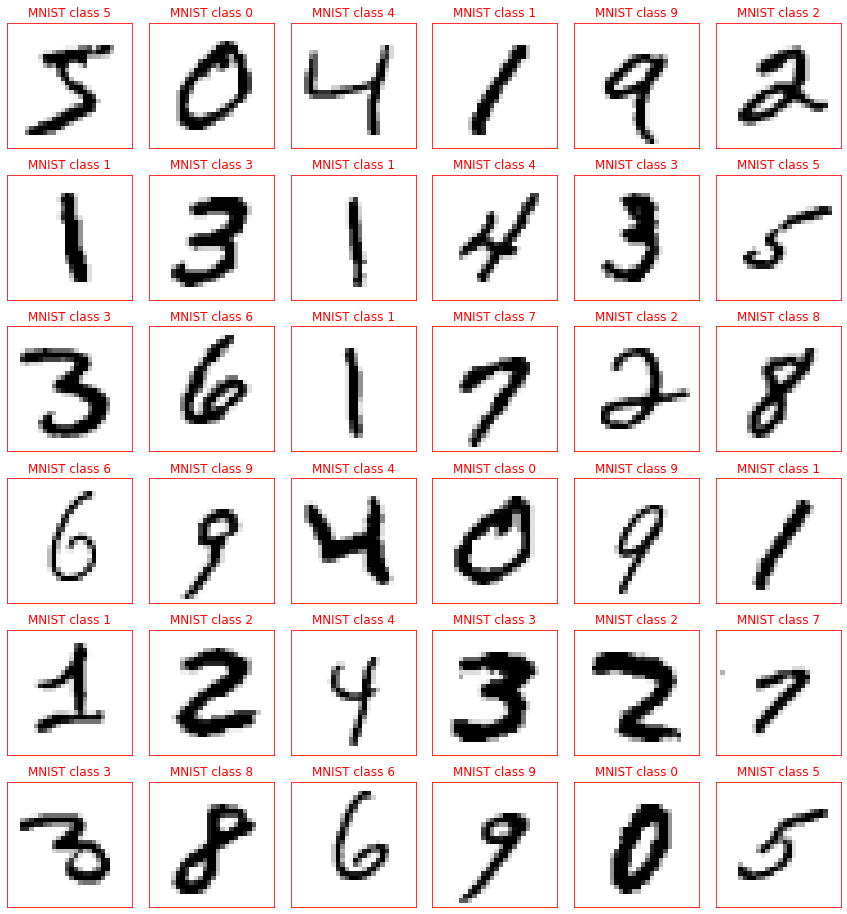

In [7]:
plot36(X0_train, y0_train, "MNIST")

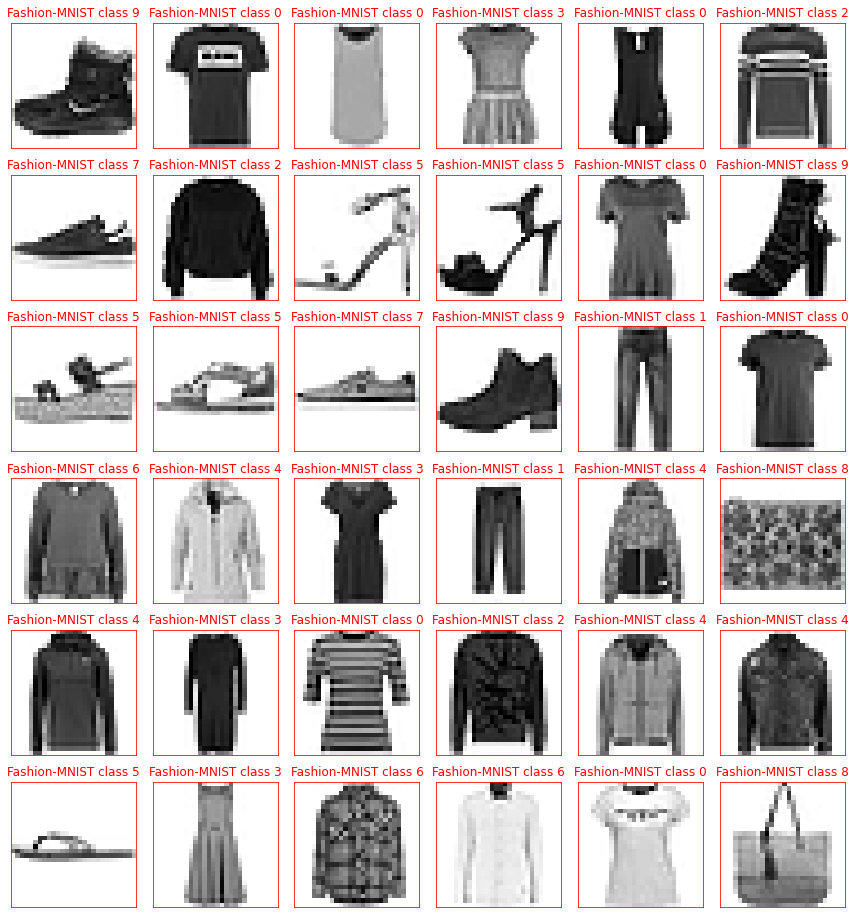

In [8]:
plot36(fX0_train, fy0_train, "Fashion-MNIST")

In [9]:
def transform(Xs, rng):
    (n, n1, n2) = Xs.shape
    Xm = Xs.copy()
    Mm = np.zeros((n, 2, 2)).astype("int32")
    R1 = np.array([[0, 1], [-1, 0]])
    for i,X in enumerate(Xs):
        M = np.eye(2)
        X1 = X.copy()
        if rng.random() < 0.5:
            X1 = np.flip(X1, axis=1)
            M[1] *= -1 # HACK; GUESS
        nrot = rng.integers(0,4)
        for j in range(nrot):
            X1 = np.rot90(X1, 1)
            M = M @ R1
        Xm[i] = X1
        Mm[i] = M
    return Xm, Mm

def minusify_1(X, y, N, rng):
    (n, n1, n2) = X.shape
    assert n1 == n2
    assert y.shape == (n, )
    inds = rng.integers(0, n, N)
    ym = np.zeros(N).astype(int)
    ym = y[inds]
    Xm, Mm = transform(X[inds], rng)
    return Xm, ym, Mm

def minusify_4(X, y, N, rng):
    (n, n1, n2) = X.shape
    assert n1 == n2
    assert y.shape == (n, )
    inds = [rng.integers(0, n, N) for i in range(4)]
    ym = np.zeros(N).astype(int)
    for i in range(4):
        ym = ym + 10**i * y[inds[i]].astype(int)
    ym = np.array(["{:04d}".format(y) for y in ym])
    Xmm = np.concatenate((np.concatenate((X[inds[3]], X[inds[2]]), axis=2),
                          np.concatenate((X[inds[1]], X[inds[0]]), axis=2)),
                         axis=1)
    Xm, Mm = transform(Xmm, rng)
    return Xm, ym, Mm

def minusify_9(X, y, N, rng):
    foo = 3
    (n, n1, n2) = X.shape
    assert n1 == n2
    assert y.shape == (n, )
    inds = rng.integers(0, n, size=(N, foo, foo))
    ym = y[inds[:, 1, 1]].astype(int)
    Xmm = np.concatenate([np.concatenate([X[inds[:, i, j]] for i in range(foo)],
                                         axis=2) for j in range(foo)], axis=1)
    Xm, Mm = transform(Xmm, rng)
    return Xm, ym, Mm

In [10]:
X_trainf, y_trainf, M_trainf = minusify_1(fX0_train, fy0_train, n_train, rng)
X_testf, y_testf, M_testf = minusify_1(fX0_test, fy0_test, n_test, rng)
print("X_trainf shape", X_trainf.shape)
print("y_trainf shape", y_trainf.shape)
print("M_trainf shape", M_trainf.shape)
print("X_testf shape", X_testf.shape)
print("y_testf shape", y_testf.shape)
print("M_testf shape", M_testf.shape)

X_trainf shape (60000, 28, 28)
y_trainf shape (60000,)
M_trainf shape (60000, 2, 2)
X_testf shape (10000, 28, 28)
y_testf shape (10000,)
M_testf shape (10000, 2, 2)


In [11]:
def pickle_dataset(filename, Xtrain, Mtrain, ytrain, Xtest, Mtest, ytest):
    with open(filename, "wb") as file:
        pickle.dump(((Xtrain, Mtrain, ytrain), (Xtest, Mtest, ytest)), file)

In [12]:
pickle_dataset("Fashion++.pkl", X_trainf, M_trainf, y_trainf, X_testf, M_testf, y_testf)

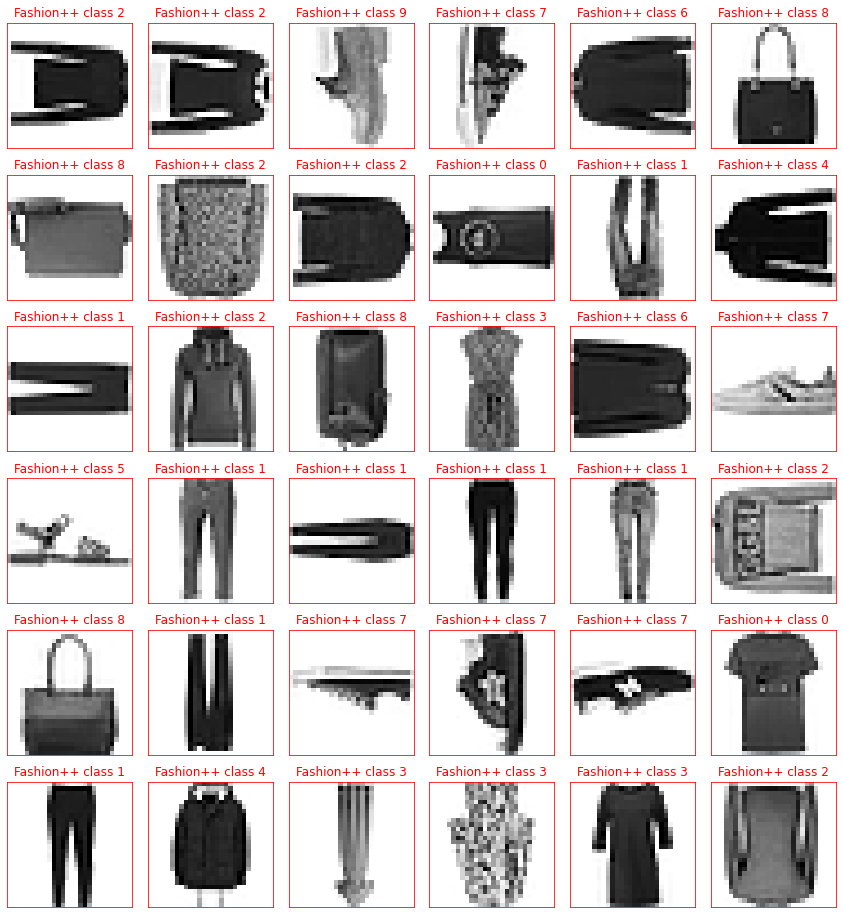

In [13]:
plot36(X_trainf, y_trainf, "Fashion++", fp="Fashion++")

In [14]:
X_train4, y_train4, M_train4= minusify_4(X0_train, y0_train, n_train, rng)
X_test4, y_test4, M_test4 = minusify_4(X0_test, y0_test, n_test, rng)
print("X_train4 shape", X_train4.shape)
print("y_train4 shape", y_train4.shape)
print("M_train4 shape", M_train4.shape)
print("X_test4 shape", X_test4.shape)
print("y_test4 shape", y_test4.shape)
print("M_test4 shape", M_test4.shape)

X_train4 shape (60000, 56, 56)
y_train4 shape (60000,)
M_train4 shape (60000, 2, 2)
X_test4 shape (10000, 56, 56)
y_test4 shape (10000,)
M_test4 shape (10000, 2, 2)


In [15]:
pickle_dataset("MNIST+4.pkl", X_train4, M_train4, y_train4, X_test4, M_test4, y_test4)

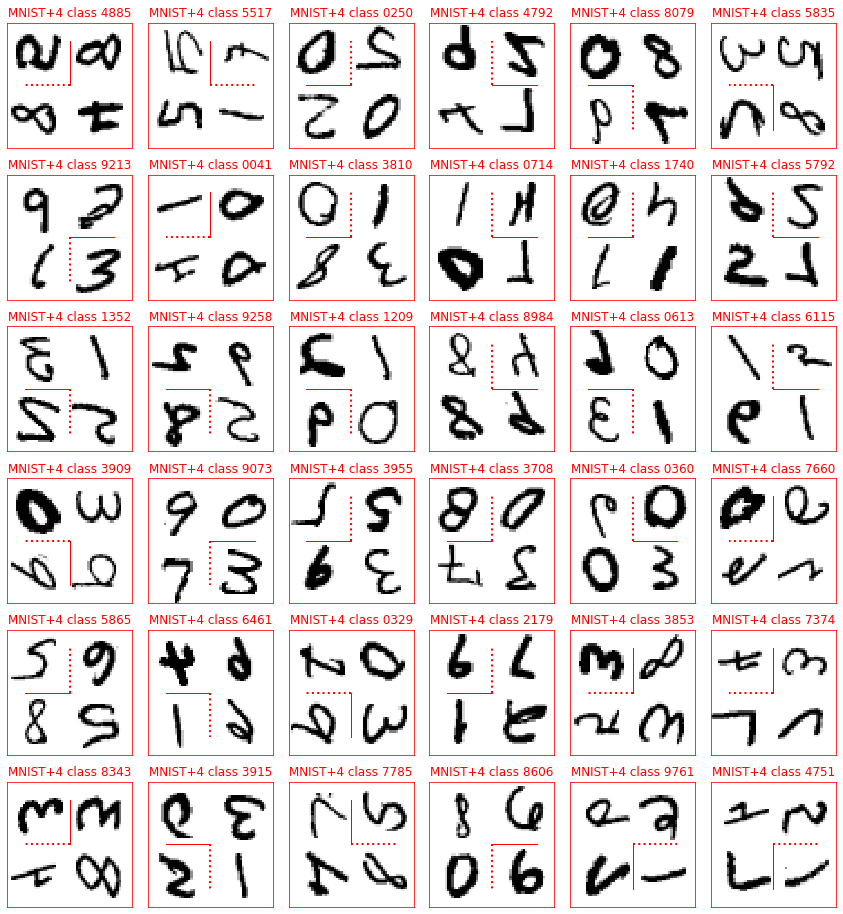

In [16]:
plot36(X_train4, y_train4, "MNIST+4", Ms=M_train4, fp="MNIST+4")

In [17]:
# Look at label statistics for MNIST+4
sstr = set(y_train4)
print("total number of labels missing from the training set:", 10000 - len(sstr))
sste = set(y_test4)
print("total number of labels missing from the test set:", 10000 - len(sste))
i = 0
for q in sste:
    if q not in sstr:
        i += 1
        print(i, "label", q, "is in the test set but not in the training set")

total number of labels missing from the training set: 20
total number of labels missing from the test set: 3701
1 label 4988 is in the test set but not in the training set
2 label 9609 is in the test set but not in the training set
3 label 6136 is in the test set but not in the training set
4 label 3477 is in the test set but not in the training set
5 label 4049 is in the test set but not in the training set
6 label 8993 is in the test set but not in the training set
7 label 5192 is in the test set but not in the training set
8 label 4150 is in the test set but not in the training set
9 label 8942 is in the test set but not in the training set
10 label 8853 is in the test set but not in the training set
11 label 3660 is in the test set but not in the training set
12 label 7504 is in the test set but not in the training set


In [18]:
X_train9, y_train9, M_train9 = minusify_9(X0_train, y0_train, n_train, rng)
X_test9, y_test9, M_test9 = minusify_9(X0_test, y0_test, n_test, rng)
print("X_train9 shape", X_train9.shape)
print("y_train9 shape", y_train9.shape)
print("M_train9 shape", M_train9.shape)
print("X_test9 shape", X_test9.shape)
print("y_test9 shape", y_test9.shape)
print("M_test9 shape", M_test9.shape)

X_train9 shape (60000, 84, 84)
y_train9 shape (60000,)
M_train9 shape (60000, 2, 2)
X_test9 shape (10000, 84, 84)
y_test9 shape (10000,)
M_test9 shape (10000, 2, 2)


In [19]:
pickle_dataset("MNIST+9.pkl", X_train9, M_train9, y_train9, X_test9, M_test9, y_test9)

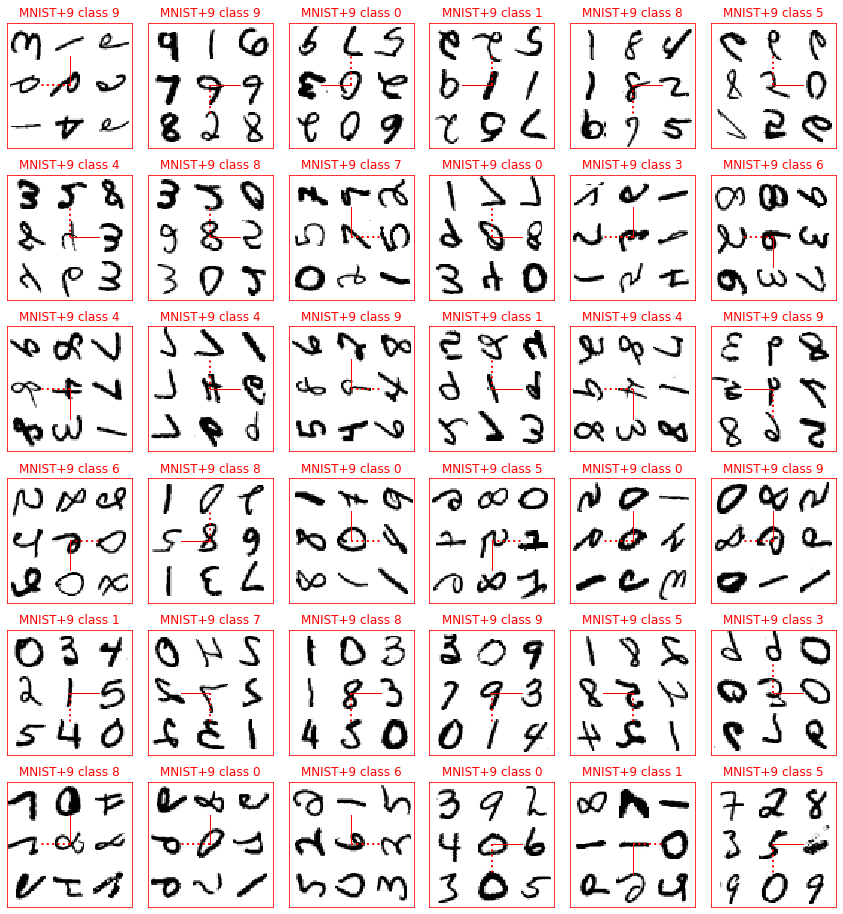

In [20]:
plot36(X_train9, y_train9, "MNIST+9", Ms=M_train9, fp="MNIST+9")

In [21]:
def infinity_transform(Xs, n1, n2, rng):
    (n, in_n1, in_n2) = Xs.shape
    Xm = np.zeros((n, n1, n2))
    xyout = np.array(np.meshgrid(np.arange(0.25, n1, 0.5) - 0.5 * n1, np.arange(0.25, n2, 0.5) - 0.5 * n2))
    Mm = np.zeros((n, 2, 2))
    for i,X in enumerate(Xs):
        eigratio = 0.0
        while eigratio < 0.333:
            M = rng.normal(size=(2, 2))
            u, s, v = np.linalg.svd(M)
            eigratio = s[1] / s[0]
        M /= np.sqrt(np.prod(s))
        xyin = np.tensordot(M, xyout, (1, 0))
        yin = np.floor(np.clip(xyin[0] + 0.5 * in_n1, 0., in_n1-0.5)).astype(int) ## HACKS
        xin = np.floor(np.clip(xyin[1] + 0.5 * in_n2, 0., in_n2-0.5)).astype(int)
        foo = X[yin, xin]
        X1 = foo.reshape(n1, 2, n2, 2).mean(-1).mean(1) # bin down 2x2
        Xm[i] = X1
        Mm[i] = np.flip(np.linalg.inv(M).T, axis=1) # I don't understand why this HACK is necessary
    return Xm, Mm

def minusify_infinity(X, y, N, rng):
    foo = 7
    (n, n1, n2) = X.shape
    assert n1 == n2
    assert y.shape == (n, )
    inds = rng.integers(0, n, size=(N, foo, foo))
    ym = y[inds[:, foo // 2, foo // 2]].astype(int)
    Xmm = np.concatenate([np.concatenate([X[inds[:, i, j]] for i in range(foo)],
                                         axis=2) for j in range(foo)], axis=1)
    Xm, Mm = infinity_transform(Xmm, 3 * n1, 3 * n2, rng)
    return Xm.astype("uint8"), ym, Mm

In [22]:
X_trainInf, y_trainInf, M_trainInf = minusify_infinity(X0_train, y0_train, n_train, rng)
X_testInf, y_testInf, M_testInf = minusify_infinity(X0_test, y0_test, n_test, rng)
print("X_trainInf shape", X_trainInf.shape)
print("y_trainInf shape", y_trainInf.shape)
print("M_trainInf shape", M_trainInf.shape)
print("X_testInf shape", X_testInf.shape)
print("y_testInf shape", y_testInf.shape)
print("M_testInf shape", M_testInf.shape)

X_trainInf shape (60000, 84, 84)
y_trainInf shape (60000,)
M_trainInf shape (60000, 2, 2)
X_testInf shape (10000, 84, 84)
y_testInf shape (10000,)
M_testInf shape (10000, 2, 2)


In [23]:
pickle_dataset("MNIST+Inf.pkl", X_trainInf, M_trainInf, y_trainInf, X_testInf, M_testInf, y_testInf)

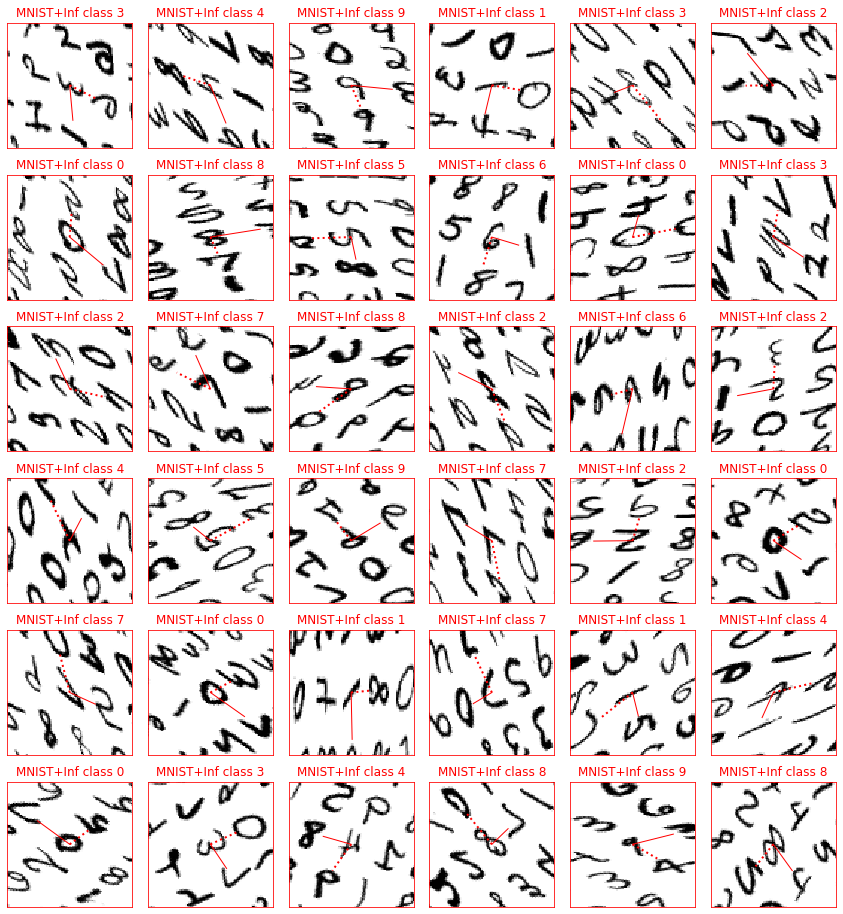

In [24]:
plot36(X_trainInf, y_trainInf, "MNIST+Inf", Ms=M_trainInf, fp="MNIST+Inf")

In [25]:
os.system("gzip --force --best *.pkl")

0